# 2. Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.



## 2.1 Load dataset and vectorize

A classifier of news is going to be built to assign 20 news categories. Let's import the dataset and check the different categories:

In [1]:
# Import libraries
from sklearn.datasets import fetch_20newsgroups # Data function that dowloads the data from archive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from pprint import pprint
from time import time
import itertools


from pathlib import Path # to check if file exists
import os # get current directory
import pickle


# imported because of the splitting of the questions:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import dataset
newsgroups = fetch_20newsgroups(subset='all')#, remove = ('headers', 'footers', 'quotes'))

# Show categories list
pprint(list(newsgroups.target_names))
classes = newsgroups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


Let's check the dataset shape and how is like each datapoint:

In [3]:
import pandas as pd
from pandas.io.json import json_normalize

# The real data lies in the filenames and target attributes(target category)
print('Filenames shape:', newsgroups.filenames.shape)
print('Target shape:',newsgroups.target.shape,'\n')

# Show 
print('The categories of newsgroups are: ',list(pd.DataFrame.from_dict(json_normalize(newsgroups), orient='columns').columns),'\n')
print('description is: ',newsgroups.description)
print('filenames contains the location of the files in the hardware running the code ')

Filenames shape: (18846,)
Target shape: (18846,) 

The categories of newsgroups are:  ['DESCR', 'data', 'description', 'filenames', 'target', 'target_names'] 

description is:  the 20 newsgroups by date dataset
filenames contains the location of the files in the hardware running the code 


now we vectorize the data:
* small max_features is faster and reduces a bit the chances of overfitting
* if word in max_df portion of the files then it get ignored
* strip eventual accents (even though we should not have problems with english)
* for this current version we can only eliminate "english" key word, even though it should already be taken by max_df!!

In [4]:
# Vectorize the text dataset
vectorizer = TfidfVectorizer(max_features=10000,\
                             max_df=0.7,\
                             strip_accents = 'ascii',
                             stop_words='english')
vectors = vectorizer.fit_transform(newsgroups.data)
vectors.shape

(18846, 10000)

### Split in training, testing and validation sets

Split training (80%), testing(10%) and validation (10%) sets

In [5]:
# Create predictors and predicted variable
X = vectors
y = newsgroups.target

# Split training, testing and validation tests
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.8) # 80% train
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=0, train_size=0.5) # 10% test, 10% validation

/home/zampieri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
seed = 50

# Create a fit the classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=seed)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [10]:
# to printwith different fonts
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [13]:
# First Evaluation
print (color.BOLD + 'Initial score:' + color.END)
print('Train score:',rfc.score(X_train, y_train))
print('Test score:',rfc.score(X_test, y_test))
print('Validation score:',color.RED+str(rfc.score(X_val, y_val))+color.END)

Initial score:
Train score: 1.0
Test score: 0.830769230769
Validation score: 0.82599469496


The result is quite good, but the Train score at 1.0 is really not nice!

Here are the #features and the features importance

In [14]:
print('Number of features:',rfc.n_features_)
print('Features importances:',rfc.feature_importances_)
print('Maximal importance of a feature:',max(rfc.feature_importances_))
depths = pd.Series([estimator.tree_.max_depth for estimator in rfc.estimators_])
print ('\nDepths: \n',depths.describe())


Number of features: 10000
Features importances: [  5.74276830e-04   2.07053299e-04   1.25403332e-04 ...,   1.30413849e-06
   2.50585632e-04   8.65350439e-06]
Maximal importance of a feature: 0.0101609887333

Depths: 
 count    100.00000
mean     305.48000
std       35.92008
min      223.00000
25%      278.50000
50%      304.50000
75%      329.25000
max      385.00000
dtype: float64


Watching at the max depth statistical description all estimators will help us to know how to tune better this parameter.

### Grid search for finding better parameters
Since the computation are long, we are gonna save the results in pickle files as advised by the TA's

###  Saving functions
We used them to write to a binary file the content of a given variable, in our case it will be the content of grid search. The goal being to not recompute the results each time. We saved all thoses _.pickle_ files in the subdirectory **pickles/**

In [23]:
DATA_FOLDER = 'pickles/'

# function to save results in a pickle file
def save_results(var_name, file_name):
    file_path = DATA_FOLDER + file_name +'.pickle'
    my_file = Path(file_path)
    my_dir = Path(DATA_FOLDER)
    if not(my_dir.is_dir()):
        os.makedirs(DATA_FOLDER)
        save_results(var_name, file_name)
    elif my_file.is_file():
        print('WARNING! This filename already exusted so we wrote in "overrided.pickle" PLEASE MANUALLY CHANGE THE NAME'+\
             '\n CHancge the file name with your name')
        with open(DATA_FOLDER + 'overrided.pickle', 'wb') as file:
            pickle.dump(var_name, file)
    else:
        with open(file_path, 'wb') as file:
            pickle.dump(var_name, file)

# Function to read the pickles file
def read_pickle(file_name):
    file_path = DATA_FOLDER + str(file_name) + '.pickle'
    with open(file_path, "rb") as file:
        out = pickle.load(file)
    return out

# function to prin the scores
def print_scores(grid_search_var):
    print('Train score:',grid_search_var.score(X_train, y_train))
    print('Test score:',grid_search_var.score(X_test, y_test))
    print('Validation score:',color.RED+str(grid_search_var.score(X_val, y_val))+color.END)
    
# since in the following we will change the max number of features, here is a function that does that
def change_max_features_number(max_features,max_df=0.7):
    newsgroups = fetch_20newsgroups(subset='all')
    classes = newsgroups.target_names
    vectorizer = TfidfVectorizer(max_features=max_features,\
                                 max_df=max_df,\
                                 strip_accents = 'ascii',
                                 stop_words='english')
    vectors = vectorizer.fit_transform(newsgroups.data)
    # Create predictors and predicted variable
    X = vectors
    y = newsgroups.target

    # Split training, testing and validation tests
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.8) # 80% train
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=0, train_size=0.5) # 10% test, 10% validation
    return X_train, y_train, X_test, X_val, y_test, y_val

**Here is the code that we usually use for grid-searching:**

``` python
# Parameters of the grid search
#n_estim_range = np.round(np.logspace(1,2.5,num=8,dtype=int)) # used for other runs
#max_depth_range = np.round(np.logspace(1,3.5,num=8,dtype=int)) # used for other runs
n_estim_range = [200, 400, 700]
max_depth_range = [50, 100, 200, 500, 600, 900]

paramgrid = {'n_estimators': n_estim_range,'max_depth': max_depth_range}

# Grid search on the number of estimators
grid_search = GridSearchCV(RandomForestClassifier(random_state=seed), paramgrid, cv = 3)
grid_search.fit(X_train, y_train)
print('Best parameters:',grid_search.best_params_)

# Evaluation
print('Train score:',grid_search.score(X_train, y_train))
print('Test score:',grid_search.score(X_test, y_test))
print('Validation score:',grid_search.score(X_val, y_val))
```

** and here is the one for saving the parameters in a pickle file:**
>``` python
save_results(grid_search, 'removing_features_1')
```

We dont use them here since we only load the previously obtained results.

## Run removing headers, footers and quotes
First we recompute our train and tests sets:

In [28]:
newsgroups = fetch_20newsgroups(subset='all',remove = ('headers', 'footers', 'quotes'))
classes = newsgroups.target_names
vectorizer = TfidfVectorizer(max_features=10000,\
                             max_df=0.7,\
                             strip_accents = 'ascii',
                             stop_words='english')
vectors = vectorizer.fit_transform(newsgroups.data)
# Create predictors and predicted variable
X = vectors
y = newsgroups.target

# Split training, testing and validation tests
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.8) # 80% train
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=0, train_size=0.5) # 10% test, 10% validation

/home/zampieri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Then we can take a look at the results:

In [29]:
removed_features_GS = read_pickle('removing_features_1')

print('Run with "remove = ("headers", "footers", "quotes")" and with the following set of parameters:\n'+\
      'n_estim_range = [200, 400, 700]\n'+\
      'max_depth_range = [50, 100, 200, 500, 600, 900]\n')

print('Optimal features found: ',removed_features_GS.best_params_)
print('which gave the following results:')
# Evaluation
print_scores(removed_features_GS) 

Run with "remove = ("headers", "footers", "quotes")" and with the following set of parameters:
n_estim_range = [200, 400, 700]
max_depth_range = [50, 100, 200, 500, 600, 900]

Optimal features found:  {'max_depth': 500, 'n_estimators': 400}
which gave the following results:
Train score: 0.971875829132
Test score: 0.663129973475
Validation score: 0.640848806366


**Discussion:** We can see that removing the headers, footers and quotes decreases our accuracy of preditcion, even if it is in some sense a more thruthfull classification since only the content is analysed. <br />
**Thus in the rest of the analysis we thus not remove the features, but we should keep in mind that consideration**<br />
So we recompute the training and testss sets withour removing the headers, footers and quotes:

In [30]:
X_train, y_train, X_test, X_val, y_test, y_val = change_max_features_number(10000)

/home/zampieri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Now the grid search:
a first run (we cannot reload the pickle file for incompatibilities here so we hard-coded the results) for the other we will be able to load the pickle files.

In [49]:
#nightly_run_1 = read_pickle('gilcompa')
print('Run with without removing anything and with the following set of parameters:\n'+\
      'n_estim_range = [ 316  464  681 1000]\n'+\
      'max_depth_range = [ 1000  2154  4641 10000]\n')

print('We found:\n'+\
      'best n_estimators = 1000\n'+\
     'best max_depth = 1000\n'+\
     'train score = 1.0\n'+\
     'test_score = 0.841909814324\n'+\
     'val_score = 0.835013262599')

#print('Optimal features found: ',nightly_run_1.best_params_)


Run with without removing anything and with the following set of parameters:
n_estim_range = [ 316  464  681 1000]
max_depth_range = [ 1000  2154  4641 10000]

We found:
best n_estimators = 1000
best max_depth = 1000
train score = 1.0
test_score = 0.841909814324
val_score = 0.835013262599


**Discussion:** It seems that the bigger the _n_estimators_ the better. On the other hand the max_depth seems not to be reached. The overfitting (1.0 on the training set) is inacceptable.

We thus reduce both ranges a do another run:

In [48]:
nightly_run_2 = read_pickle('martino')
print('Run with the following set of parameters:\n'+\
      'max_depth_range = [300, 500, 700, 900]\n'+\
      'n_estim_range = [200, 500, 900]\n')
print('Optimal features found: ',nightly_run_2.best_params_)
print('which gave the following results:')
# Evaluation
print_scores(nightly_run_2) 

Run with "remove = ("headers", "footers", "quotes")" and with the following set of parameters:
max_depth_range = [300, 500, 700, 900]
n_estim_range = [200, 500, 900]

Optimal features found:  {'max_depth': 300, 'n_estimators': 900}
which gave the following results:
Train score: 1.0
Test score: 0.841379310345
Validation score: 0.835543766578


**Discussion:** Slightly better results have been obtained with smaller parameters. However, the strong overfitting is still present. We may then change approach and reduce the maximum number of features.

## Reduced number of features

we freeze the number of estimators and the max depth to 400 to reduce the computational cost of this operation. We realize that this is far from optimal but it is just to have a better understanding of how it works.<br>
Since we will recompute often the sets changing the number of features we define the following function: 

We recompute training and tests with 5000 max_features:

In [35]:
X_train, y_train, X_test, X_val, y_test, y_val = change_max_features_number(5000)

/home/zampieri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [36]:
reduced_5000 = read_pickle('5000_max_features')
print('We used fixed depth and estimators for this quick analysis: \n'+"max_depth = 400, n_estimators = 400}\n")
print('Optimal features found: ',reduced_5000.best_params_)
print('which gave the following results:')
# Evaluation
print_scores(reduced_5000) 

We used fixed depth and estimators for this quick analysis: 
max_depth = 400, n_estimators = 400}

Optimal features found:  {'max_depth': 400, 'n_estimators': 400}
which gave the following results:
Train score: 0.999933669408
Test score: 0.826525198939
Validation score: 0.823342175066


**Discussion:** We finnaly don't get 1.0 as training but we are still very close to one... But lets see what happens.

We recompute training and tests with 7000 max_features:

In [37]:
X_train, y_train, X_test, X_val, y_test, y_val = change_max_features_number(7000)

/home/zampieri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [38]:
reduced_7000 = read_pickle('7000_max_features')
print('We used fixed depth and estimators for this quick analysis: \n'+"max_depth = 400, n_estimators = 400}\n")
print('Optimal features found: ',reduced_7000.best_params_)
print('which gave the following results:')
# Evaluation
print_scores(reduced_7000) 

We used fixed depth and estimators for this quick analysis: 
max_depth = 400, n_estimators = 400}

Optimal features found:  {'max_depth': 400, 'n_estimators': 400}
which gave the following results:
Train score: 0.999933669408
Test score: 0.833421750663
Validation score: 0.828116710875


**Discussion:** the validation score increased from 0.8233 to 0.8281 which is a small inproovement.

Lets go back to 10000:

In [31]:
X_train, y_train, X_test, X_val, y_test, y_val = change_max_features_number(10000)

/home/zampieri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [32]:
reduced_10000 = read_pickle('10000_max_features')
print('We used fixed depth and estimators for this quick analysis: \n'+"max_depth = 400, n_estimators = 400}\n")
print('Optimal features found: ',reduced_10000.best_params_)
print('which gave the following results:')
# Evaluation
print_scores(reduced_10000) 

We used fixed depth and estimators for this quick analysis: 
max_depth = 400, n_estimators = 400}

Optimal features found:  {'max_depth': 400, 'n_estimators': 400}
which gave the following results:
Train score: 1.0
Test score: 0.836604774536
Validation score: 0.836074270557


**Discussion:** It gets a bit better again so we will continue... (even though we are again at 1.0 on the training which is really bad!)

In [55]:
X_train, y_train, X_test, X_val, y_test, y_val = change_max_features_number(60000)

/home/zampieri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [56]:
reduced_60000 = read_pickle('50000_max_features') # yes, the name is wrong haha
print('We used fixed depth and estimators for this quick analysis: \n'+"max_depth = 400, n_estimators = 400}\n")
print('Optimal features found: ',reduced_60000.best_params_)
print('which gave the following results:')
# Evaluation
print_scores(reduced_60000) 

We used fixed depth and estimators for this quick analysis: 
max_depth = 400, n_estimators = 400}

Optimal features found:  {'max_depth': 400, 'n_estimators': 400}
which gave the following results:
Train score: 1.0
Test score: 0.860477453581
Validation score: 0.856233421751


**Discussion:** We see that it keeps improoving even if there is that huge training score (that may be a bit problematic for the grid search)

##### We can now see the influence of max_df:
We compute the sets with 10000 max_features and 0.8 of max_df:

In [61]:
X_train, y_train, X_test, X_val, y_test, y_val = change_max_features_number(10000,0.8)

/home/zampieri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [62]:
reduced_10000_08_max_df = read_pickle('08_max_df_10000_max_features')
print('We used fixed depth and estimators for this quick analysis: \n'+"max_depth = 400, n_estimators = 400}\n")
print('Optimal features found: ',reduced_10000_08_max_df.best_params_)
print('which gave the following results:')
# Evaluation
print_scores(reduced_10000_08_max_df) 

We used fixed depth and estimators for this quick analysis: 
max_depth = 400, n_estimators = 400}

Optimal features found:  {'max_depth': 400, 'n_estimators': 400}
which gave the following results:
Train score: 1.0
Test score: 0.836604774536
Validation score: 0.836074270557


**Discussion:** which doesn't change anything, so we will let it at 0.7

# Partial conclusion:
The bes tup to now is the one with a lot of max features and with a large number of estimators. Unfortunately we don't have the time to increase those parameters so we will be satisfied with **0.856233421751** as validation score.
On the contrary, the max depth has to be kept lower because otherwise the overfitting will be too important. The lower the features number the lower should the depth of the tree be to avoid excessive overfitting.


# Confusion matrix

Using the template found here: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

we plotted the confusion matrix for one of the best cases: 

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [60]:
# give the right dimensions to the sets
X_train, y_train, X_test, X_val, y_test, y_val = change_max_features_number(60000)

/home/zampieri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Normalized confusion matrix


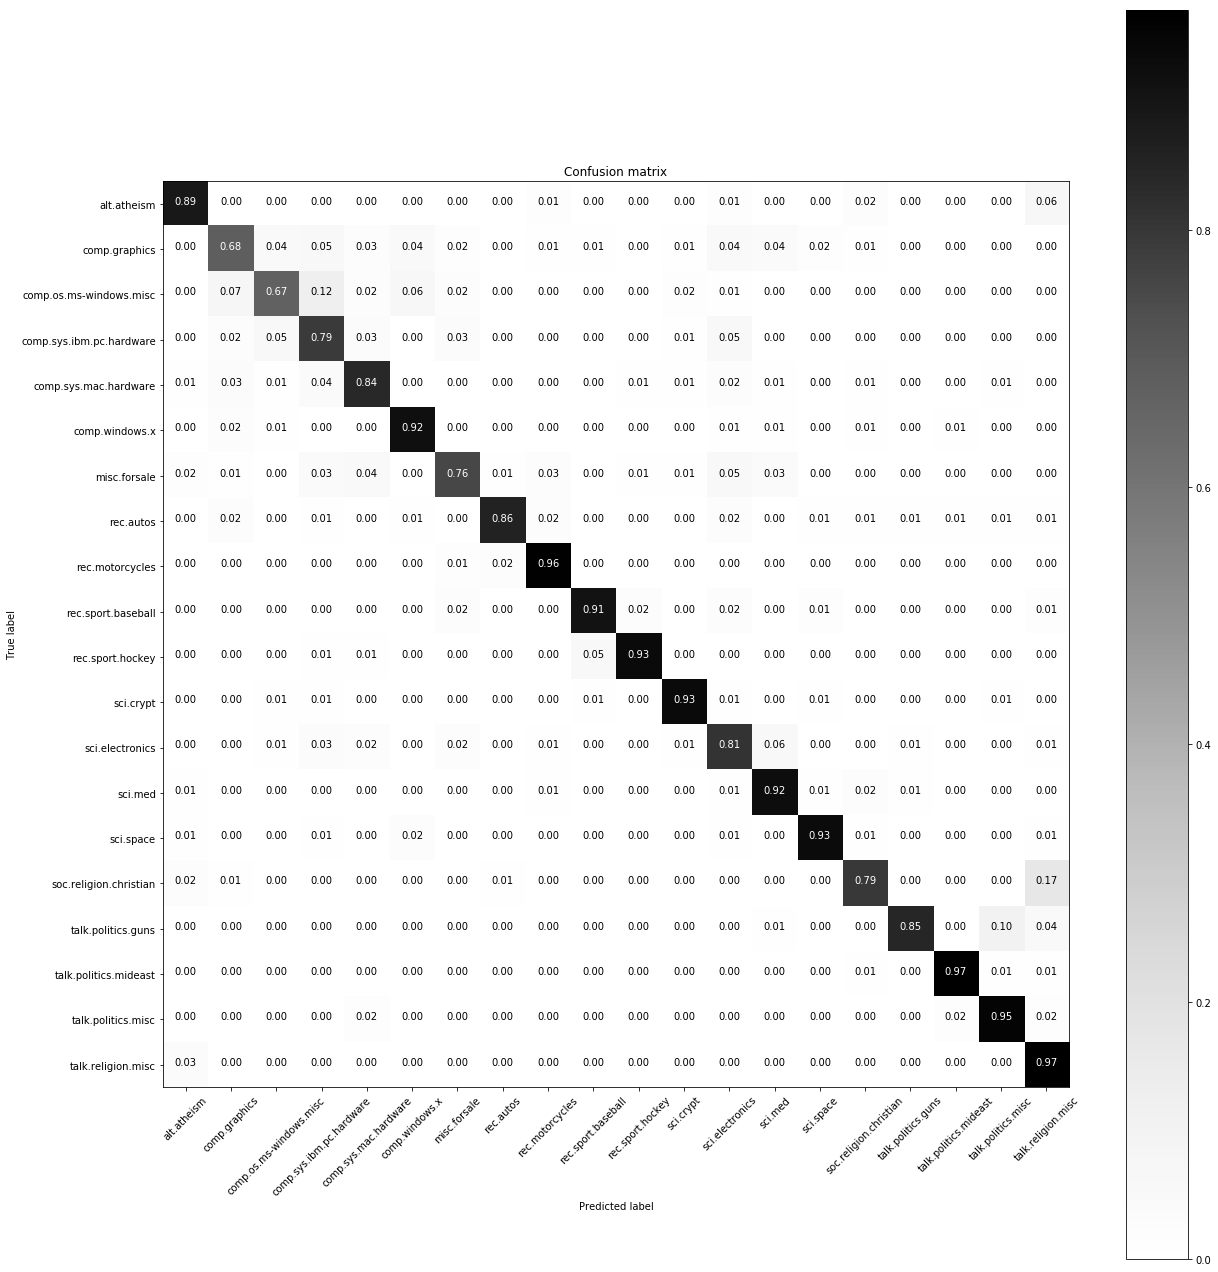

In [57]:
best_run = reduced_60000
y_pred = best_run.predict(X_val)
cm = confusion_matrix(y_pred, y_val)

plt.figure(figsize=(18,18))
plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Greys);
plt.show()

We observe that there is confusion on similar subjets like **soc.religion.christian** with **talk.religion.misc**, **talk.politics.misc** with **talk.politics.guns** and so on.
We could use different methods on those closes subjects to further improve the accuracy!

## 2.2.Results discussion

In [66]:
# give the right dimensions to the sets
X_train, y_train, X_test, X_val, y_test, y_val = change_max_features_number(60000) # run if needed
best_run.estimator.fit(X_train, y_train)

/home/zampieri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [68]:
print('Number of features:',best_run.estimator.n_features_)
print('Features importances:',best_run.estimator.feature_importances_)
depths = pd.Series([estimator.tree_.max_depth for estimator in rfc.estimators_])
depths.describe()

Number of features: 60000
Features importances: [ 0.00059091  0.00030749  0.         ...,  0.          0.          0.        ]


count    100.00000
mean     305.48000
std       35.92008
min      223.00000
25%      278.50000
50%      304.50000
75%      329.25000
max      385.00000
dtype: float64

In [47]:
best_run.estimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [50]:
rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)